# Create an ODE based simple model
The `COVID-19` has a latent period of 6-14 days ($1/\gamma$), and basic Reproduction rate ($R_0$) around [2.38](https://static.poder360.com.br/2020/03/science-estudo-coronavirus-contagio-documentacao-16-mar-2020.pdf).
 
Estimated the mean basic reproduction number(R0) of SARS-CoV-2 to range between 2.24 (95% CI: 1.96-2.55) and 3.58 (95% CI: 2.89-4.39) in the early phase of the [outbreak](https://doi.org/10.1101/2020.02.11.20022186).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

_path = './data/state-reports-2020-03-28.csv'
# _path_xl = './data/KeralaCovidOnset.xlsx'

In [2]:
# covid_dfxl = pd.read_excel(_path_xl, sheet_name='District Wise Data', 
#                            parse_dates=['Date']).groupby(['District','Date']).sum().reset_index()
# district_name = 'Total'
# covid_dfxl_total = covid_dfxl.loc[covid_dfxl['District']==district_name].set_index('Date')
# covid_dfxl_total

In [3]:
use_cols = ['Corona positive', 'Cured discharged', 'Deaths','Created at']
covid_df = pd.read_csv(_path, usecols=use_cols, parse_dates=['Created at'])
covid_df['date'] = covid_df['Created at'].apply(lambda x: pd.to_datetime(x.date))

In [4]:
fit_param_dat = covid_df.set_index('date').sort_index().loc[pd.to_datetime('2020-03-01'):,['Corona positive','Cured discharged']]

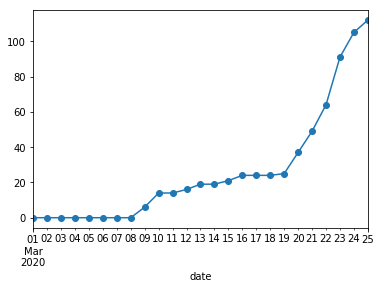

In [5]:
fit_param_dat['Corona positive'].plot(marker='o')
plt.show()

## Fit the Data to Estimate Parameters

In [6]:
from pygom import common_models, SquareLoss
from pygom import DeterministicOde, Transition, SimulateOde, TransitionType
import graphviz
import scipy
from scipy.optimize import minimize
import numpy as np

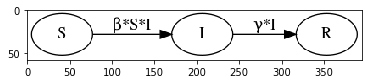

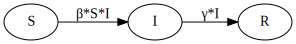

In [7]:
common_models.SIR().get_transition_graph()

In [8]:
R_0 = 2.4 # (beta/gamma)
N = 33_000_000 # Pop of Kerala
gamma = 1/8 # Avg time an individual remain infectious in days^(-1)
beta = gamma*R_0

# Standard SIR model with 2 parameters
paramEval = {'beta':beta, 'gamma':gamma}
# initialize the model
ode = common_models.SIR(paramEval)

initial_infected=3 # as on 2020-03-08 (start date)

ini_prop = (initial_infected/N)

x0 = [1-ini_prop, ini_prop, 0]

n_1 = fit_param_dat.shape[0]
t = np.linspace(0,n_1,n_1+1)

We provide a guess for $\beta$ and $\gamma$. We have information about the infected and removed population, up to 17 days of the epidemic.

In [9]:
theta = [beta, gamma]
# theta
# fit_param_dat.values
# x0
I_R_act = fit_param_dat.values/N
# I_R_act.shape

In [10]:
# Initial guess of parameters, and bounding constraints
boxBounds = [(0.0,0.5),(0.0,0.5)]
objSIR = SquareLoss(theta, ode, x0, t[0], t[1::], I_R_act, ['I','R'])

In [11]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='SLSQP')
print(res)

     fun: 1.2959922878633859e-10
     jac: array([ 7.08445066e-09, -5.76150198e-09])
 message: 'Optimization terminated successfully.'
    nfev: 1
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.3  , 0.125])


In [12]:
res.x

array([0.3  , 0.125])

In [13]:
# model with fitted parameters 
ode_fit = common_models.SIR({'beta':res.x[0], 'gamma':res.x[1]})

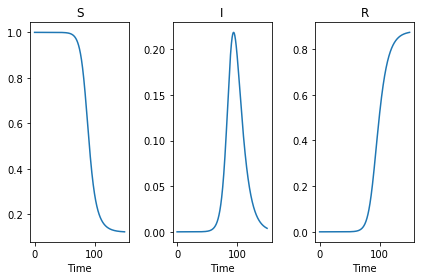

Peak infection (days) 94.0
R0 (beta/gamma) =  2.4


In [14]:
x0_fit = x0
t_fit = np.linspace(0, 150, 1000)
ode_fit.initial_values = (x0_fit, t_fit[0])
sol_fit = ode_fit.integrate(t_fit[1::])
ode_fit.plot()

peak_i = np.argmax(sol_fit[:,1])
print('Peak infection (days)', round(t_fit[peak_i]))
print('R0 (beta/gamma) = ', res.x[0]/res.x[1])

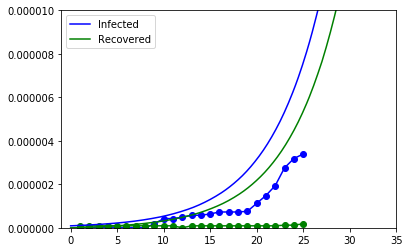

In [15]:
plt.plot(t[1:],I_R_act[:,0], 'b-o') # infected observations
plt.plot(t[1:],I_R_act[:,1], 'g-o') # removed observations (recoverd/died)
plt.plot(t_fit, sol_fit[:,1], 'b', label='Infected')
plt.plot(t_fit, sol_fit[:,2], 'g', label='Recovered')
plt.legend()

plt.ylim(0,1e-5)
plt.xlim(-1,35)

plt.show()

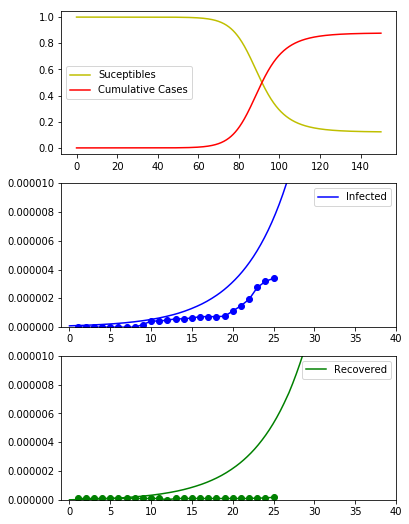

In [16]:
fig, ax = plt.subplots(3,1, figsize=(6,9))
ax[1].plot(t[1:],I_R_act[:,0], 'b-o') # infected observations
ax[2].plot(t[1:],I_R_act[:,1], 'g-o') # removed observations (recoverd/died)
ax[0].plot(t_fit, sol_fit[:,0], 'y', label='Suceptibles')
ax[0].plot(t_fit, 1-sol_fit[:,0], 'r', label='Cumulative Cases')
ax[1].plot(t_fit, sol_fit[:,1], 'b', label='Infected')
ax[2].plot(t_fit, sol_fit[:,2], 'g', label='Recovered')

ax[1].set_xlim(-1,40)
ax[1].set_ylim(0,1e-5)
ax[2].set_xlim(-1,40)
ax[2].set_ylim(0,1e-5)
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

## Stochastic Simulations

In [6]:
def get_shape_rate(mean, std):
    rate = mean/std**2
    return mean*rate, rate

In [7]:
get_shape_rate(0.125,0.0001)

(1562500.0, 12500000.0)

In [27]:
# construct model 
states = ['S', 'I', 'R']
params = ['beta', 'gamma', 'N']
transitions = [Transition(origin='S', destination='I', equation='beta*S*I/N', 
                          transition_type=TransitionType.T),
               Transition(origin='I', destination='R', equation='gamma*I', 
                          transition_type=TransitionType.T)]

model_p = SimulateOde(states, params, transition=transitions)

In [38]:
# define parameter distributions
from pygom.utilR import rgamma

d = dict()
d['beta'] = (rgamma, {'shape':9000.0, 'rate':300000.0})
d['gamma'] = (rgamma, {'shape':156250.0, 'rate':12500000.0})
d['N'] = N

In [48]:
# initial conditions 
N = 33_000_000
in_inf = round(3)
init_state = [N - in_inf, in_inf, 0.0]

# # time 
# t = np.linspace (0 , 500 , 10001)

# deterministic parameter values
param_evals = [('beta', 0.3), ('gamma', 0.125), ('N', N)]

In [49]:
model_p.parameters = d
model_p.initial_values = (init_state, t_fit[0])

In [50]:
# solve for 10 parameter sets 
Ymean, Yall = model_p.simulate_param(t[1::], iteration=100, full_output=True)

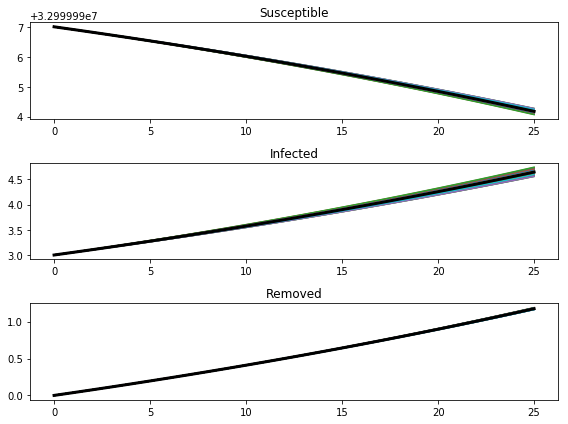

In [51]:
# plot solutions
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,6))
for i in range(np.shape(Yall)[0]):
    ax1.plot(t, Yall[i][:,0])
    ax2.plot(t, Yall[i][:,1])
    ax3.plot(t, Yall[i][:,2])
ax1.plot(t, Ymean[:,0], linewidth=3,color='k')
ax2.plot(t, Ymean[:,1], linewidth=3,color='k')
ax3.plot(t, Ymean[:,2], linewidth=3,color='k')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_title('Susceptible')
ax2.set_title('Infected')
ax3.set_title('Removed')
plt.tight_layout()

In [52]:
#!TODO Add legend with beta and gamma parameter

## Jump process

Movements between states are discrete, where the probability of transition is given by 

$Pr(process\ j\ jump\ within\ time\ \tau) = \lambda_j \exp^{-\lambda_j \tau}$.

In [53]:
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=1)

In [54]:
# construct model
model_j = SimulateOde(states, params, transition=transitions)
model_j.parameters = param_evals
model_j.initial_values = (init_state, t[0])

In [55]:
# run 100 simulations
simX, simT = model_j.simulate_jump(t[1::], iteration=100, 
                                   full_output=True, parallel=True)

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(6,12))

for sim in simX:
    ax[0].plot(simX[0][:,0])
    ax[1].plot(simX[0][:,1])
    ax[2].plot(simX[0][:,2])
plt.tight_layout()
plt.show()